In [28]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc as AUC

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#### Used data

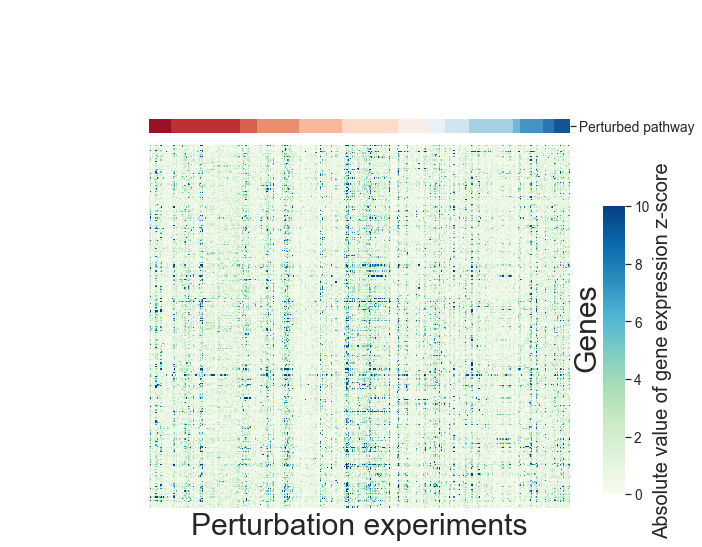

In [15]:
data=pd.read_csv('../results/benchmark/datasets/progeny_data.csv',sep=',',header=0,index_col=0).abs()
data[data<-10]=-10
data[data>10]=10
meta=pd.read_csv('../results/benchmark/datasets/progeny_meta.csv',sep=',',header=0,index_col=0)
meta.columns=['Perturbed pathway']
col_col=dict(zip(meta['Perturbed pathway'].unique(), sns.color_palette('RdBu',14)))
sns.set(font_scale=1.25)
g=sns.clustermap(data.iloc[:300,],cmap='GnBu',col_colors=meta['Perturbed pathway'].map(col_col),
               row_cluster=False,col_cluster=False,
               cbar_pos=(0.85, .30, .03, .4),rasterized=True)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_xlabel('Perturbation experiments',size=30)
g.ax_heatmap.set_ylabel('Genes',size=30)
g.ax_cbar.set_ylabel('Absolute value of gene expression z-score',size=20)
plt.savefig('../figures/raw/Fig3A1.pdf')

0.867385458682387 0.6752249457027615


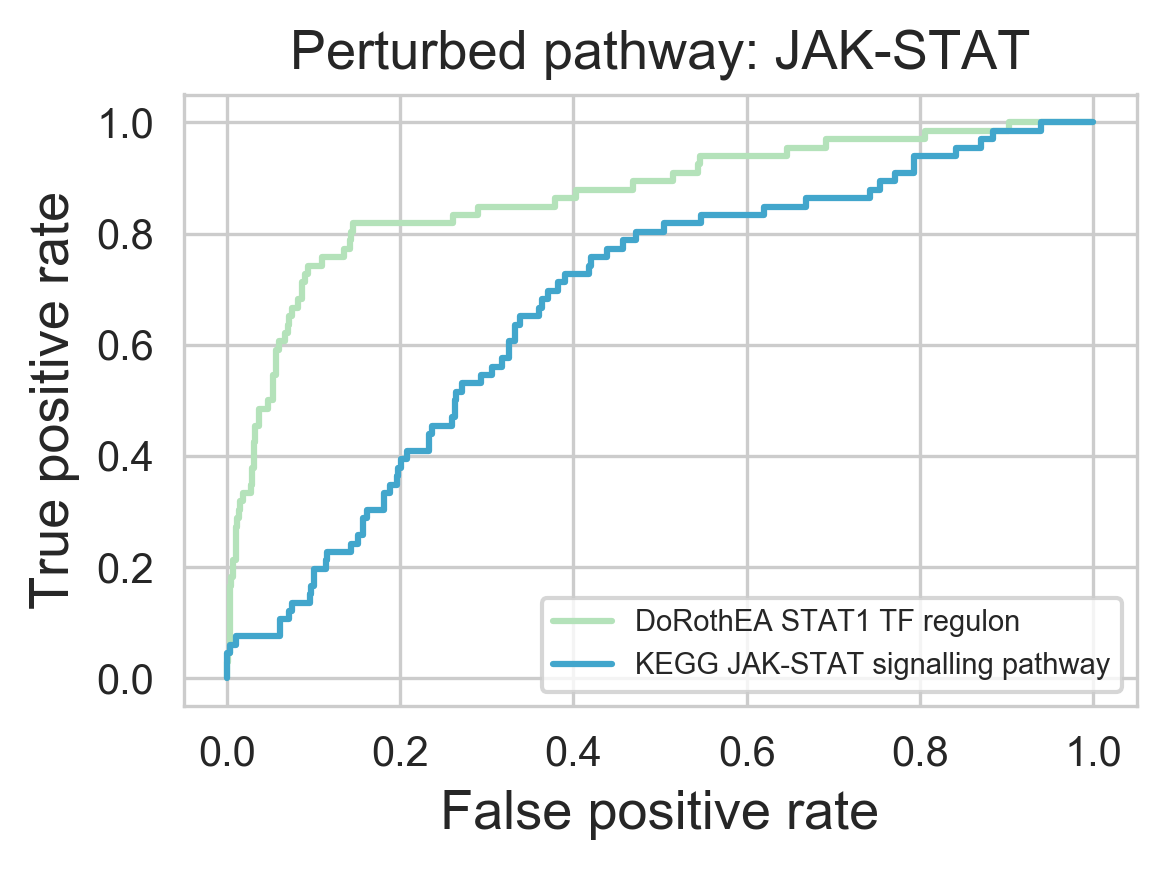

In [5]:
dorothea=pd.read_csv('../results/benchmark/scores/progeny/single/BEST_dorothea_AB_filtered_abs.csv',
                     sep=',',header=0,index_col=0)
kegg=pd.read_csv('../results/benchmark/scores/progeny/single/KEGG_filtered_abs.csv',
                     sep=',',header=0,index_col=0)
meta=pd.read_csv('../results/benchmark/datasets/progeny_meta.csv',sep=',',header=0,index_col=0)
y_pr1=dorothea.loc['STAT1']
y_pr2=kegg.loc['KEGG_JAK_STAT_SIGNALING_PATHWAY']
y_tr=(meta['pathway']=='JAK-STAT')*1
fpr1,tpr1,th=ROC(y_true=y_tr,y_score=y_pr1)
fpr2,tpr2,th=ROC(y_true=y_tr,y_score=y_pr2)
auc1=AUC(fpr1,tpr1)
auc2=AUC(fpr2,tpr2)
sns.set_palette('GnBu',2)
plt.figure(figsize=(4,3),dpi=300)
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.xlabel('False positive rate',size=13)
plt.ylabel('True positive rate',size=13)
plt.title('Perturbed pathway: JAK-STAT',size=13)
plt.legend(['DoRothEA STAT1 TF regulon','KEGG JAK-STAT signalling pathway'],fontsize=7)
plt.tight_layout()
print(auc1,auc2)
plt.savefig('../figures/raw/Fig3A2.pdf')

In [14]:
data=pd.read_csv('../results/benchmark/z_scores/progeny/single/BEST_dorothea_AB_filtered_abs.csv',
                sep=',',header=0,index_col=0)
data=data.sort_index()

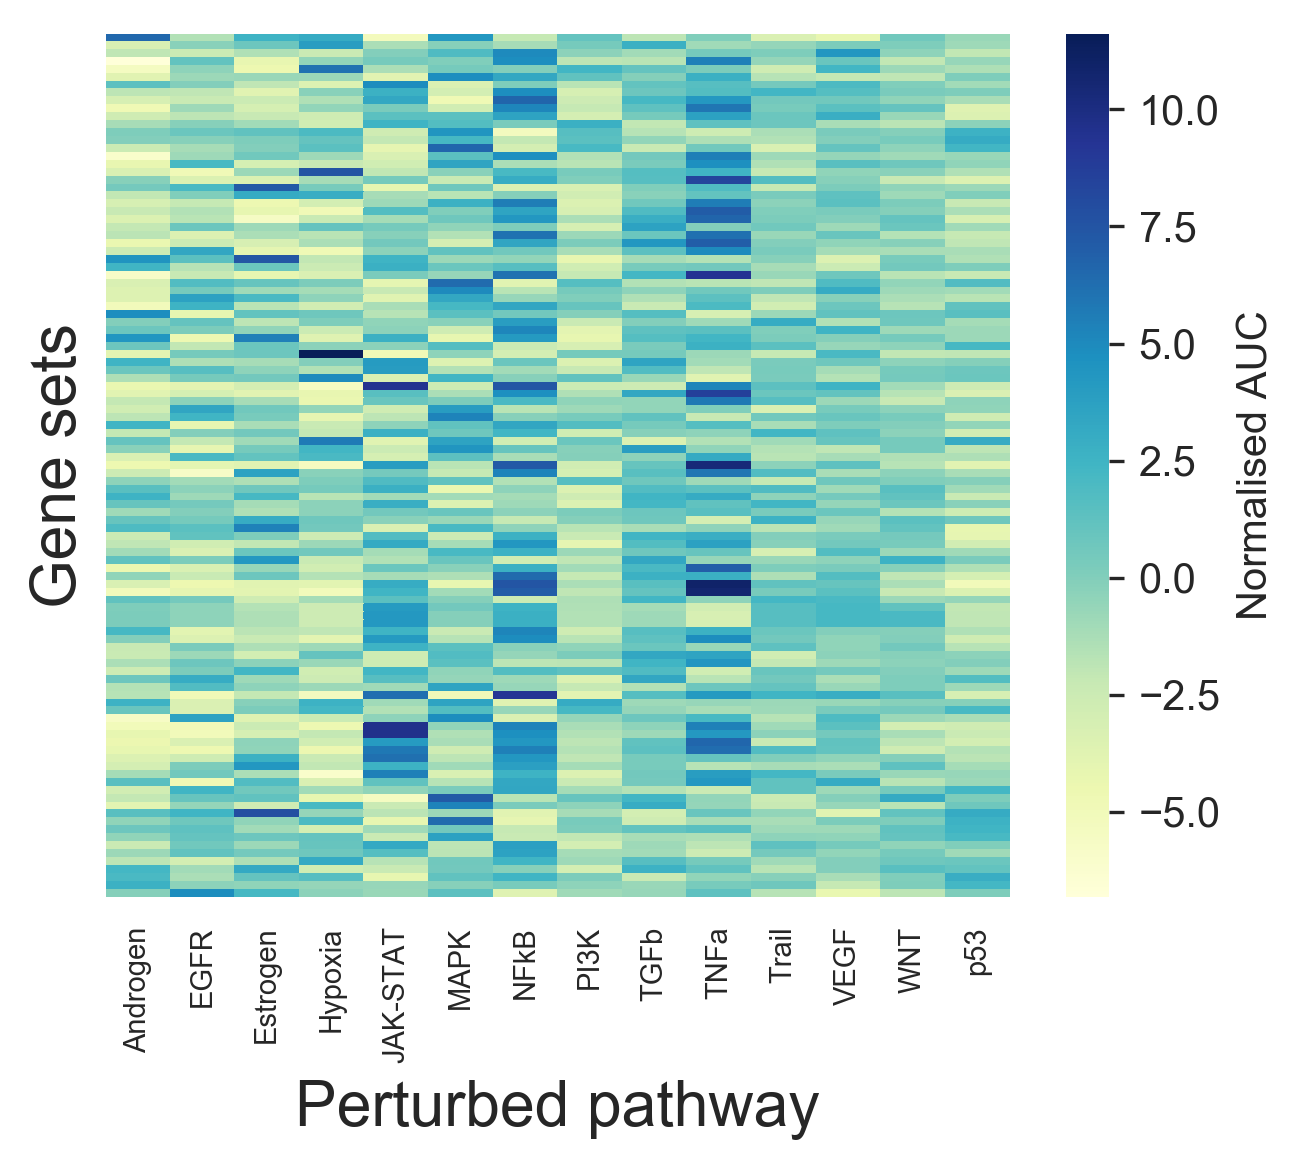

In [15]:
plt.figure(figsize=(4.5,4),dpi=300)
sns.heatmap(data,cmap='YlGnBu',cbar_kws={'label': 'Normalised AUC'})
plt.xlabel('Perturbed pathway',size=15)
plt.ylabel('Gene sets',size=15)
plt.yticks([])
plt.xticks(size=7)
plt.tight_layout()
plt.savefig('../figures/raw/Fig3A3.pdf')

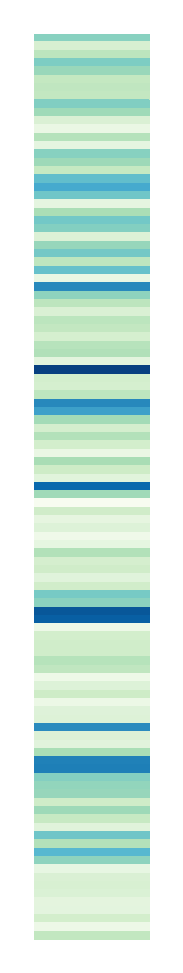

In [12]:
plt.figure(figsize=(0.5,4),dpi=300)
sns.heatmap(pd.DataFrame(data.abs().max(1)),cmap='GnBu',cbar=None)
plt.yticks([])
plt.xticks([])
plt.ylabel('')
plt.xlabel('')
plt.savefig('../figures/raw/Fig3A4.pdf')

#### Top informative gene sets

In [58]:
databases=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
results=pd.DataFrame(index=range(5),columns=databases)
for dset in results.columns:
    data=pd.read_csv('../results/benchmark/z_scores/progeny/single/%s_filtered_abs.csv' % dset,
                    sep=',',header=0,index_col=0)
    max_values = data.abs().values.reshape((1,-1))[0]
    max_values.sort()
    max_values=max_values[-5:][::-1]
    for i in results.index:
        fil = data.abs()==max_values[i]
        results.loc[i,dset]=fil.sum(0).sort_values().index[-1]+ ' ' + fil.sum(1).sort_values().index[-1]
results.to_csv('../results/benchmark/top_progeny.csv',sep=',')       

In [60]:
databases=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
results=pd.DataFrame(index=range(5),columns=databases)
for dset in results.columns:
    data=pd.read_csv('../results/benchmark/z_scores/gdsc/single/%s_filtered_abs.csv' % dset,
                    sep=',',header=0,index_col=0)
    max_values = data.abs().values.reshape((1,-1))[0]
    max_values.sort()
    max_values=max_values[-5:][::-1]
    for i in results.index:
        fil = data.abs()==max_values[i]
        results.loc[i,dset]=fil.sum(0).sort_values().index[-1]+ ' ' + fil.sum(1).sort_values().index[-1]
results.to_csv('../results/benchmark/top_gdsc.csv',sep=',')   

#### Maximum informative scores

In [2]:
def plot_maximal_infromative_score(bmark='progeny',abs_type='_abs',fname='Figure3B'):
    databases=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
    results=pd.DataFrame(columns=['score','database','random'])
    for dset in databases:
        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bmark,dset,abs_type),
                         sep=',',header=0,index_col=0).max(1)
        results_temp=pd.DataFrame(index=range(len(data)),columns=results.columns)
        results_temp['score']=data.values
        results_temp['database']=dset
        results_temp['random']='Actual gene set'
        results=pd.concat([results,results_temp])
        results.index=range(len(results))

        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_random_dist_0%s.csv' % (bmark,dset,abs_type),
                         sep=',',header=0,index_col=0).max(1)
        results_temp=pd.DataFrame(index=range(len(data)),columns=results.columns)
        results_temp['score']=data.values
        results_temp['database']=dset
        results_temp['random']='Random gene set'
        results=pd.concat([results,results_temp])
        results.index=range(len(results))
    results.columns=['score','database','Gene set']
    plt.figure()
    plt.figure(figsize=(4,3),dpi=300)
    sns.set_palette('GnBu',2)
    sns.boxplot(x='database',y='score',hue='Gene set',data=results)
    plt.xticks(range(6),['High confidence\nDoRothEA','Low confidence\nDoRothEA','KEGG','BIOCARTA','REACTOME','CGP'],
              rotation=45)
    plt.xlabel('')
    plt.ylabel('Informative score', size=15)
    plt.tight_layout()
    plt.savefig('../figures/raw/%s.pdf' % fname)


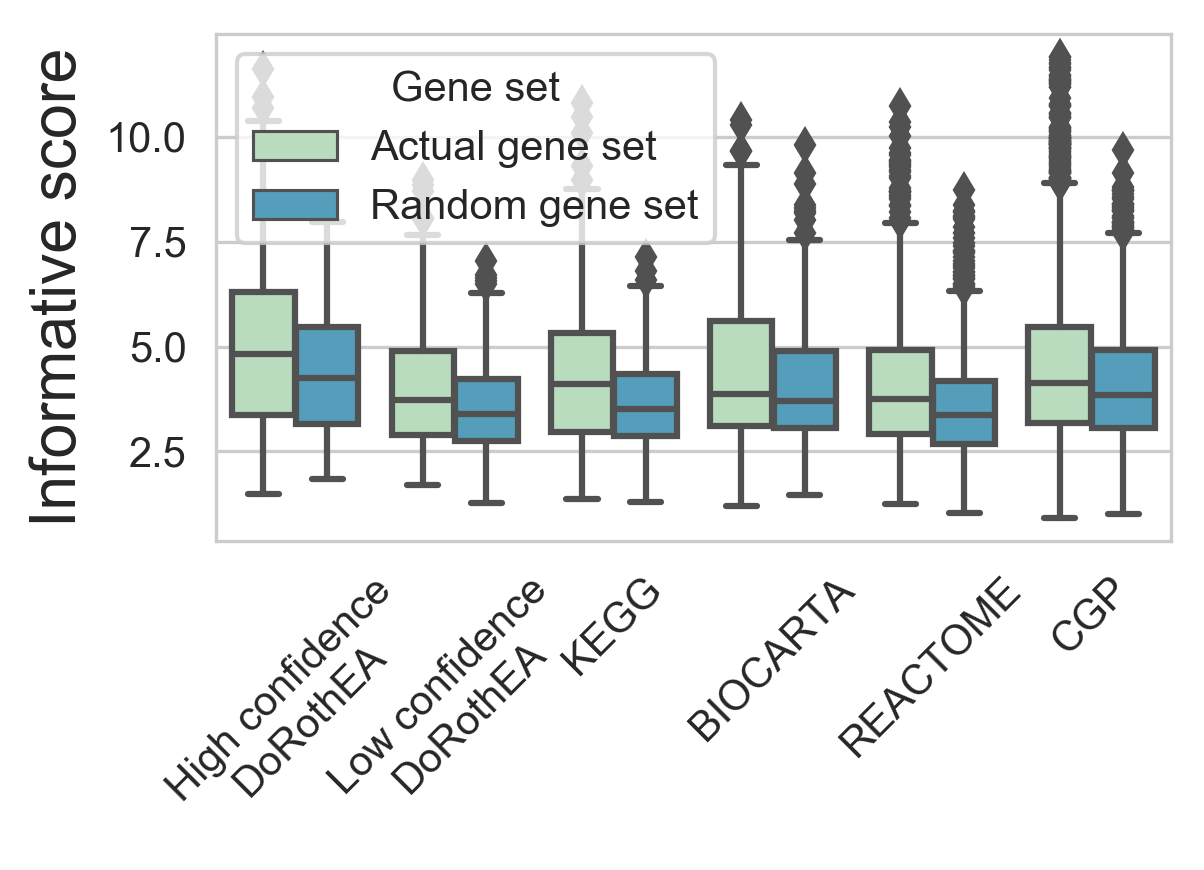

In [3]:
plot_maximal_infromative_score(bmark='progeny',abs_type='_abs',fname='Fig3B')

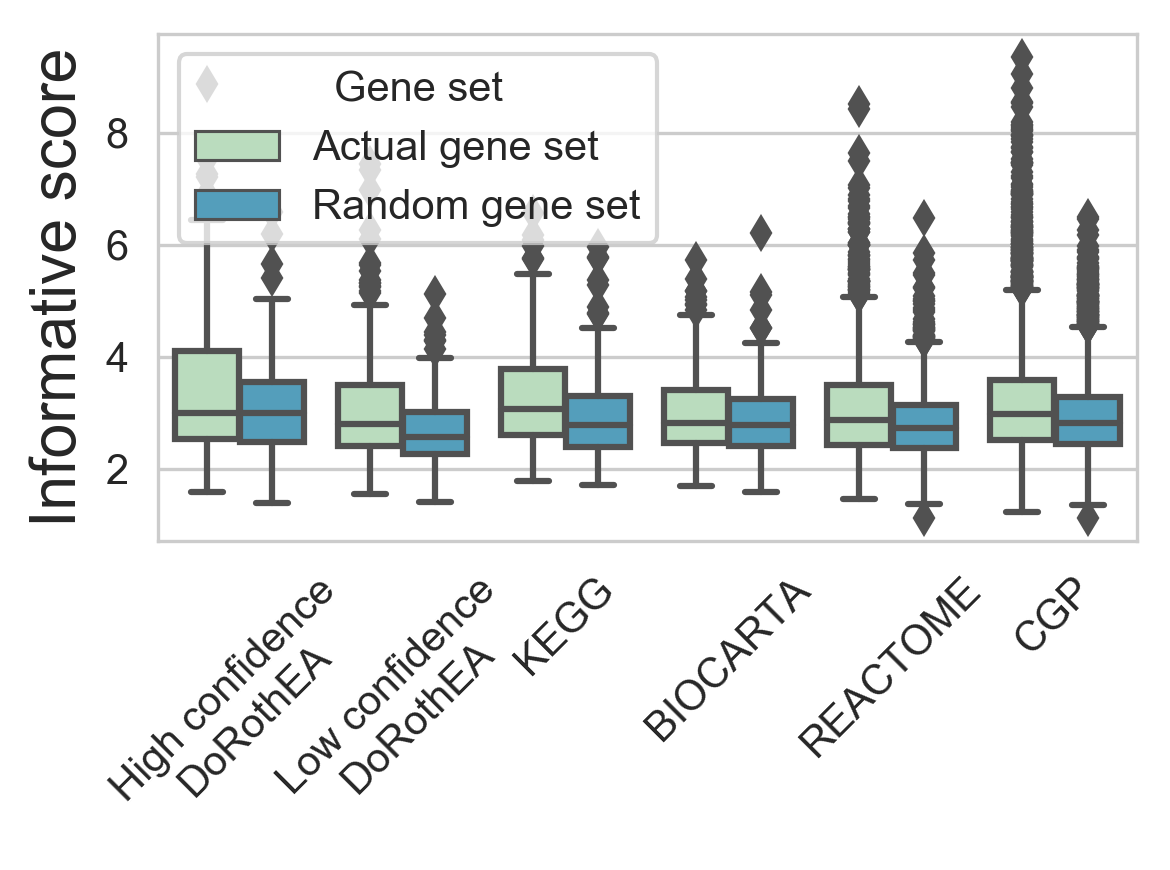

In [4]:
plot_maximal_infromative_score(bmark='gdsc',abs_type='_abs',fname='Fig3C')

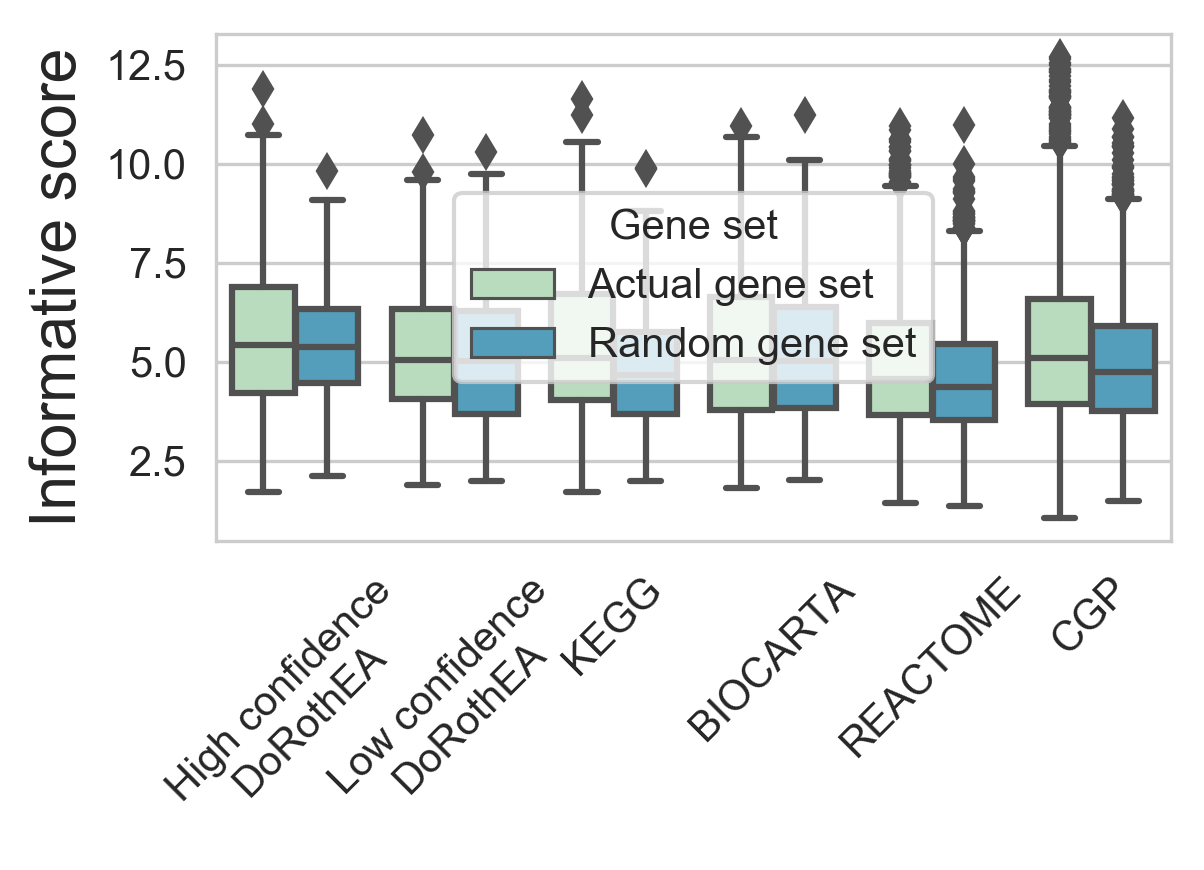

In [5]:
plot_maximal_infromative_score(bmark='progeny',abs_type='',fname='SFig4A')

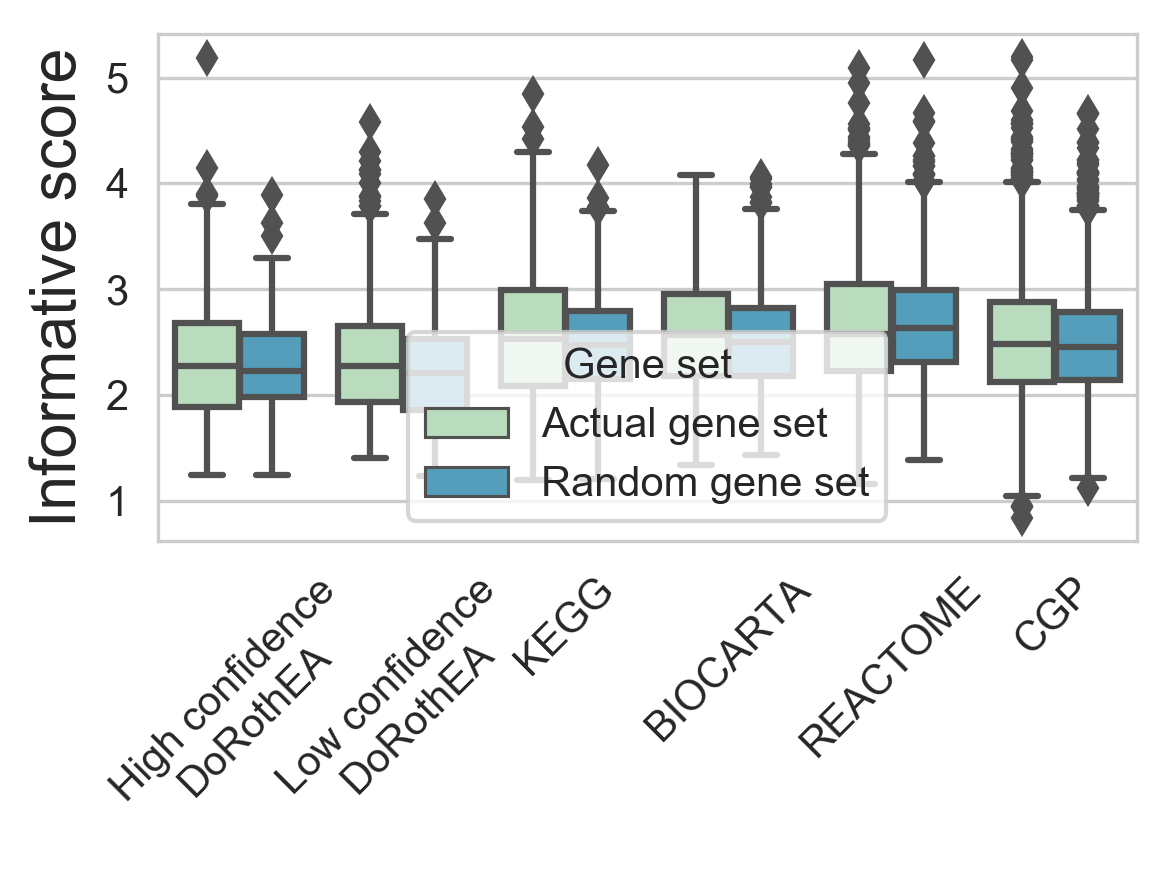

In [6]:
plot_maximal_infromative_score(bmark='gdsc',abs_type='',fname='SFig4B')

In [141]:
def calculate_maximal_infromative_statistics(bmark='progeny',abs_type='_abs'):
    databases=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
    results=pd.DataFrame(columns=['score','database','random','bmark','abs_type'])
    for dset in databases:
        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bmark,dset,abs_type),
                         sep=',',header=0,index_col=0).max(1)
        results_temp=pd.DataFrame(index=range(len(data)),columns=results.columns)
        results_temp['score']=data.values
        results_temp['database']=dset
        results_temp['random']=False
        results_temp['bmark'] = bmark
        results_temp['abs_type'] = abs_type
        results=pd.concat([results,results_temp])
        results.index=range(len(results))

        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_random_dist_0%s.csv' % (bmark,dset,abs_type),
                         sep=',',header=0,index_col=0).max(1)
        results_temp=pd.DataFrame(index=range(len(data)),columns=results.columns)
        results_temp['score']=data.values
        results_temp['database']=dset
        results_temp['random']=True
        results_temp['bmark'] = bmark
        results_temp['abs_type'] = abs_type
        results=pd.concat([results,results_temp])
        results.index=range(len(results))
    return results

    model = smf.ols('score ~ database + random',data=results).fit()
    stat_table = pd.DataFrame(columns=['ANOVA random','ANOVA gene sets',
                                   'BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP',
                                  'BEST_dorothea_CD_p','KEGG_p','BIOCARTA_p','REACTOME_p','CGP_p'])
    stat_table.loc[bmark+abs_type]=0
    stat_table.iloc[0,0]=sm.stats.anova_lm(model).loc['random','PR(>F)']
    stat_table.iloc[0,1]=sm.stats.anova_lm(model).loc['database','PR(>F)']
    stat_table.iloc[0,2:8]=model.params.values[:-1]
    stat_table.iloc[0,8:]=model.pvalues.values[1:-1]
    return stat_table

In [183]:
stat_results = pd.DataFrame(columns = ['Benchmark', 'Expression', 'ANOVA database', 'ANOVA random', 
                                       'Low confidence DoRothEA ES', 'BIOCARTA ES', 'CGP ES', 'KEGG ES', 'REACTOME ES', 
                                       'Low confidence DoRothEA p', 'BIOCARTA p', 'CGP p', 'KEGG p', 'REACTOME p'])
i = 0
for bmark in ['progeny', 'gdsc']:
    for abs_type in ['_abs', '']:
        results = calculate_maximal_infromative_statistics(bmark=bmark, abs_type=abs_type)
        model = smf.ols('score ~ database + random',data=results).fit()
        anova_database = sm.stats.anova_lm(model).loc['database', 'PR(>F)']
        temp = (-int(np.log10(anova_database))+1)
        anova_database = np.round(anova_database*10**temp,2)*10**(-temp)
        anova_random = sm.stats.anova_lm(model).loc['random', 'PR(>F)']
        temp = (-int(np.log10(anova_random))+1)
        anova_random = np.round(anova_random*10**temp,2)*10**(-temp)
        stat_results.loc[i, ['Benchmark', 'Expression']] = [bmark, abs_type]
        stat_results.loc[i, 'ANOVA database'] = anova_database
        stat_results.loc[i, 'ANOVA random'] = anova_random
        fil = results['random']==False
        tukey = pairwise_tukeyhsd(results['score'][fil], results['database'][fil])
        tukey = pd.DataFrame(tukey._results_table)
        stat_results.iloc[i, 4:9] = tukey.iloc[1:6, 2].values
        stat_results.iloc[i, 9:] = tukey.iloc[1:6, 3].values
        i+=1

In [248]:
results.to_csv('../results/benchmark/stat_table.csv', sep=',')